In [ ]:
# import csv
# import os

# # Input and output file paths
# input_file = "/home/hp/Study/Code/AI/Detecting-reversal-point-in-equity-US/detecting-reversal-points-in-us-equities/competition_data/train.csv"
# output_file = "modified_train.csv"

# # Function to process the CSV
# def process_csv(input_path, output_path):
#     with open(input_path, 'r', newline='') as infile, open(output_path, 'w', newline='') as outfile:
#         reader = csv.reader(infile)
#         writer = csv.writer(outfile)
        
#         # Read the header row
#         header = next(reader)
        
#         # Identify indices of columns with specific prefixes
#         happens_within_indices = [i for i, col in enumerate(header) if col.startswith('happens_within')]
#         occurs_within_indices = [i for i, col in enumerate(header) if col.startswith('occurs_within')]
#         crossing_above_indices = [i for i, col in enumerate(header) if col.startswith('cross_threshold_from_above')]
#         crossing_below_indices = [i for i, col in enumerate(header) if col.startswith('cross_threshold_from_below')]
#         trending_down_indices = [i for i, col in enumerate(header) if col.startswith('trending_down_and_above')]
#         trending_up_indices = [i for i, col in enumerate(header) if col.startswith('trending_up_and_below')]
#         troughs_indices = [i for i, col in enumerate(header) if col.startswith('troughs')]
#         zone_indices = [i for i, col in enumerate(header) if col.startswith('zone')]
#         peaks_indices = [i for i, col in enumerate(header) if col.startswith('peaks')]
        
#         # Keep columns that are not any of the specified prefixes
#         other_indices = [i for i, col in enumerate(header) if not (
#             col.startswith('happens_within') or 
#             col.startswith('occurs_within') or 
#             col.startswith('cross_threshold_from_above') or 
#             col.startswith('cross_threshold_from_below') or
#             col.startswith('trending_down_and_above') or
#             col.startswith('trending_up_and_below') or
#             col.startswith('troughs') or
#             col.startswith('zone') or
#             col.startswith('peaks')
#         )]
        
#         # Create new header: keep other columns, add new columns for counts
#         new_header = [header[i] for i in other_indices] + [
#             'happens_within', 
#             'occurs_within', 
#             'cross_threshold_from_above', 
#             'cross_threshold_from_below',
#             'trending_down_and_above',
#             'trending_up_and_below',
#             'troughs',
#             'zone',
#             'peaks'
#         ]
#         writer.writerow(new_header)
        
#         # Process each data row
#         for row in reader:
#             # Count "True" values in each set of columns
#             happens_within_count = sum(1 for i in happens_within_indices if row[i] == 'True')
#             occurs_within_count = sum(1 for i in occurs_within_indices if row[i] == 'True')
#             crossing_above_count = sum(1 for i in crossing_above_indices if row[i] == 'True')
#             crossing_below_count = sum(1 for i in crossing_below_indices if row[i] == 'True')
#             trending_down_count = sum(1 for i in trending_down_indices if row[i] == 'True')
#             trending_up_count = sum(1 for i in trending_up_indices if row[i] == 'True')
#             troughs_count = sum(1 for i in troughs_indices if row[i] == 'True')
#             zone_count = sum(1 for i in zone_indices if row[i] == 'True')
#             peaks_count = sum(1 for i in peaks_indices if row[i] == 'True')
            
#             # Create new row: keep other columns, add counted columns
#             new_row = [row[i] for i in other_indices] + [
#                 str(happens_within_count), 
#                 str(occurs_within_count), 
#                 str(crossing_above_count), 
#                 str(crossing_below_count),
#                 str(trending_down_count),
#                 str(trending_up_count),
#                 str(troughs_count),
#                 str(zone_count),
#                 str(peaks_count)
#             ]
#             writer.writerow(new_row)

# # Execute the processing
# process_csv(input_file, output_file)
# print(f"Processed CSV saved as {output_file}")

In [3]:
import pandas as pd
import numpy as np

# File path for train
input_file = "modified_train.csv"

# Load the CSV into a Pandas DataFrame
df = pd.read_csv(input_file)

# Simplify class labels
df['class_label'] = df['class_label'].fillna('N')
df["class_label"] = df["class_label"].replace({"HH": "H", "LH": "H", "LL": "L", "HL": "L", '': 'N'})

# Split into separate DataFrames based on ticker_id
df_001 = df[df['ticker_id'] == 1].copy()
df_002 = df[df['ticker_id'] == 2].copy()
df_003 = df[df['ticker_id'] == 3].copy() 
df_004 = df[df['ticker_id'] == 4].copy()
df_005 = df[df['ticker_id'] == 5].copy()
df_006 = df[df['ticker_id'] == 6].copy()

# Function to process each train DataFrame and create difference features
def process_dataframe(df):
    # Drop all columns except those needed for momentum_ratio and class_label
    keep_cols = ['ticker_id', 't', 'momentum', 'ratio', 'sm_momentum', 'sm_ratio', 'class_label']
    df = df[keep_cols]
    
    # Feature engineering for momentum_ratio and trailing_momentum_ratio
    df['momentum_ratio'] = df['momentum'] + df['ratio'] + df['sm_momentum'] + df['sm_ratio']
    df['trailing_momentum_ratio'] = df['momentum_ratio'].ewm(alpha=0.5, adjust=False).mean()
    
    # Drop the original components after creating momentum_ratio
    df.drop(columns=['momentum', 'ratio', 'sm_momentum', 'sm_ratio'], inplace=True)
    
    # Centralize columns by subtracting mean (per DataFrame) for the two features
    df['momentum_ratio'] = df['momentum_ratio'] - df['momentum_ratio'].mean()
    df['trailing_momentum_ratio'] = df['trailing_momentum_ratio'] - df['trailing_momentum_ratio'].mean()
    
    # Compute per-label averages for difference features
    def compute_label_averages(df):
        features = ['momentum_ratio', 'trailing_momentum_ratio']
        avg_df = df.groupby('class_label')[features].mean()
        for label in ['H', 'L', 'N']:
            if label not in avg_df.index:
                avg_df.loc[label] = 0
        return avg_df
    
    averages = compute_label_averages(df)
    
    # Create difference features based on label averages
    def create_diff_features(df, averages):
        features = ['momentum_ratio', 'trailing_momentum_ratio']
        new_features = []
        for feature in features:
            for label in ['H', 'L', 'N']:
                new_col = f'diff_{label}_{feature}'
                df[new_col] = df[feature] - averages.loc[label, feature]
                new_features.append(new_col)
        # Remove original features
        df.drop(columns=features, inplace=True)
        return df, new_features
    
    df, new_features = create_diff_features(df, averages)
    
    # Sort by time column 't'
    df.sort_values(by=['t'], inplace=True)
    
    return df

# Apply processing to each DataFrame
df_001 = process_dataframe(df_001)
df_002 = process_dataframe(df_002)
df_003 = process_dataframe(df_003)
df_004 = process_dataframe(df_004)
df_005 = process_dataframe(df_005)
df_006 = process_dataframe(df_006)

print(df_001.head())

    ticker_id           t class_label  diff_H_momentum_ratio  \
1           1  2023-04-03           N              -2.695231   
10          1  2023-04-05           N              -3.229554   
13          1  2023-04-06           N              -2.960966   
20          1  2023-04-11           N              -2.354038   
24          1  2023-04-12           N              -2.019865   

    diff_L_momentum_ratio  diff_N_momentum_ratio  \
1                0.370760              -1.026953   
10              -0.163563              -1.561276   
13               0.105025              -1.292688   
20               0.711953              -0.685760   
24               1.046126              -0.351587   

    diff_H_trailing_momentum_ratio  diff_L_trailing_momentum_ratio  \
1                        -2.261888                       -0.031903   
10                       -2.529049                       -0.299065   
13                       -2.528336                       -0.298351   
20                    

/tmp/ipykernel_550741/128606324.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['momentum_ratio'] = df['momentum'] + df['ratio'] + df['sm_momentum'] + df['sm_ratio']
/tmp/ipykernel_550741/128606324.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trailing_momentum_ratio'] = df['momentum_ratio'].ewm(alpha=0.5, adjust=False).mean()
/tmp/ipykernel_550741/128606324.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentat

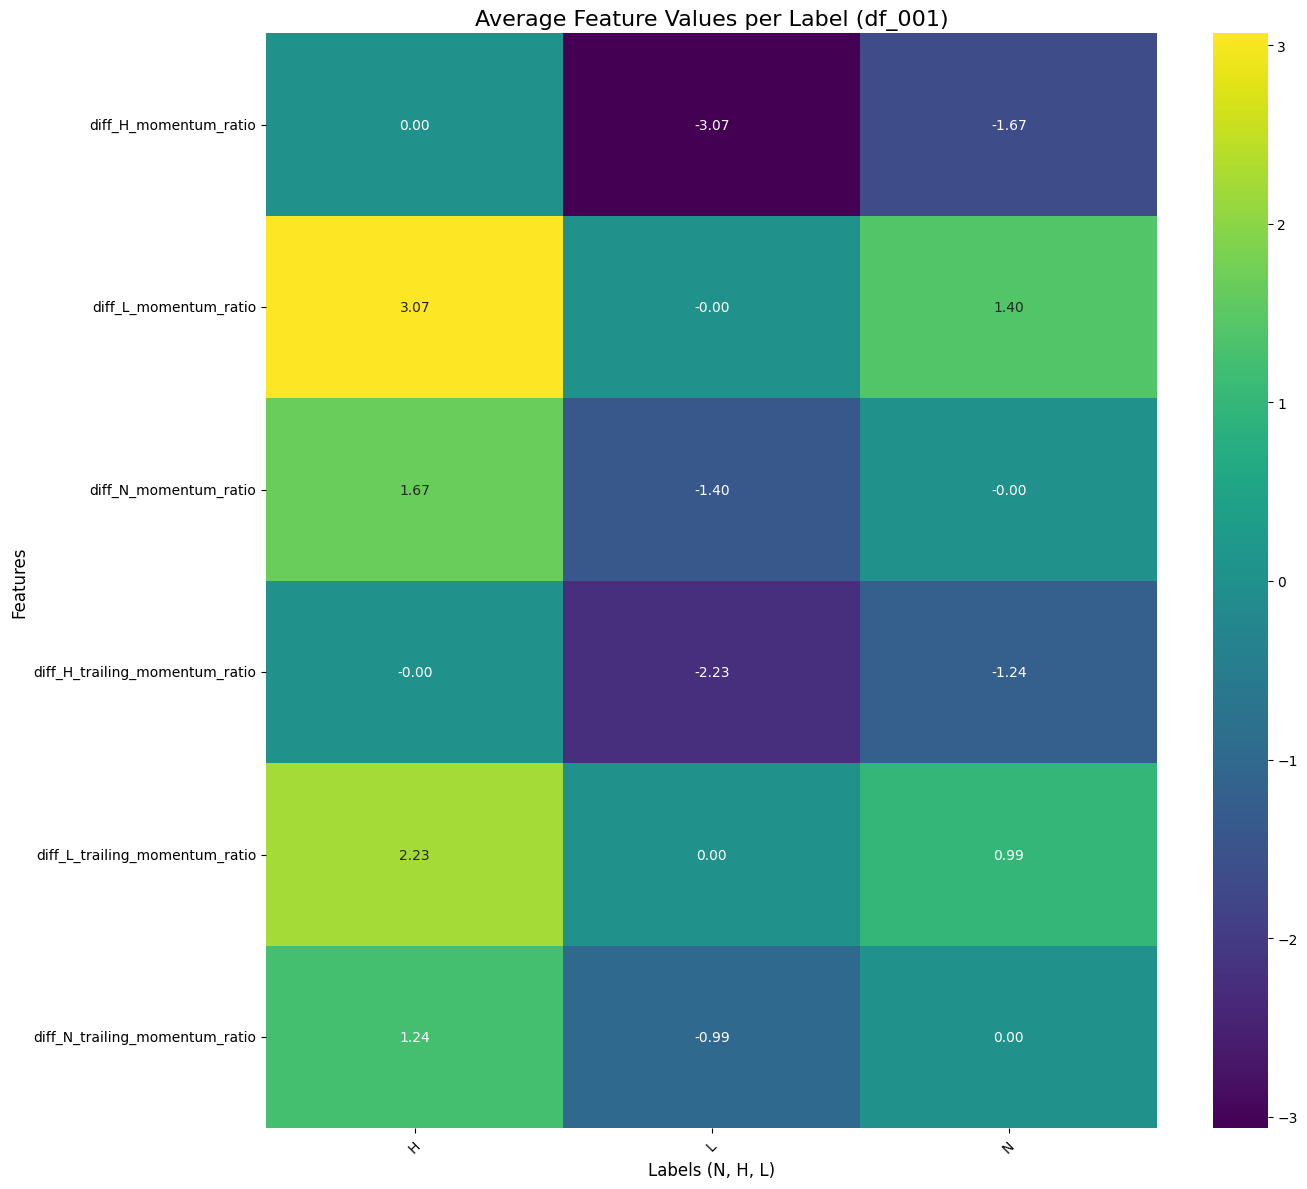

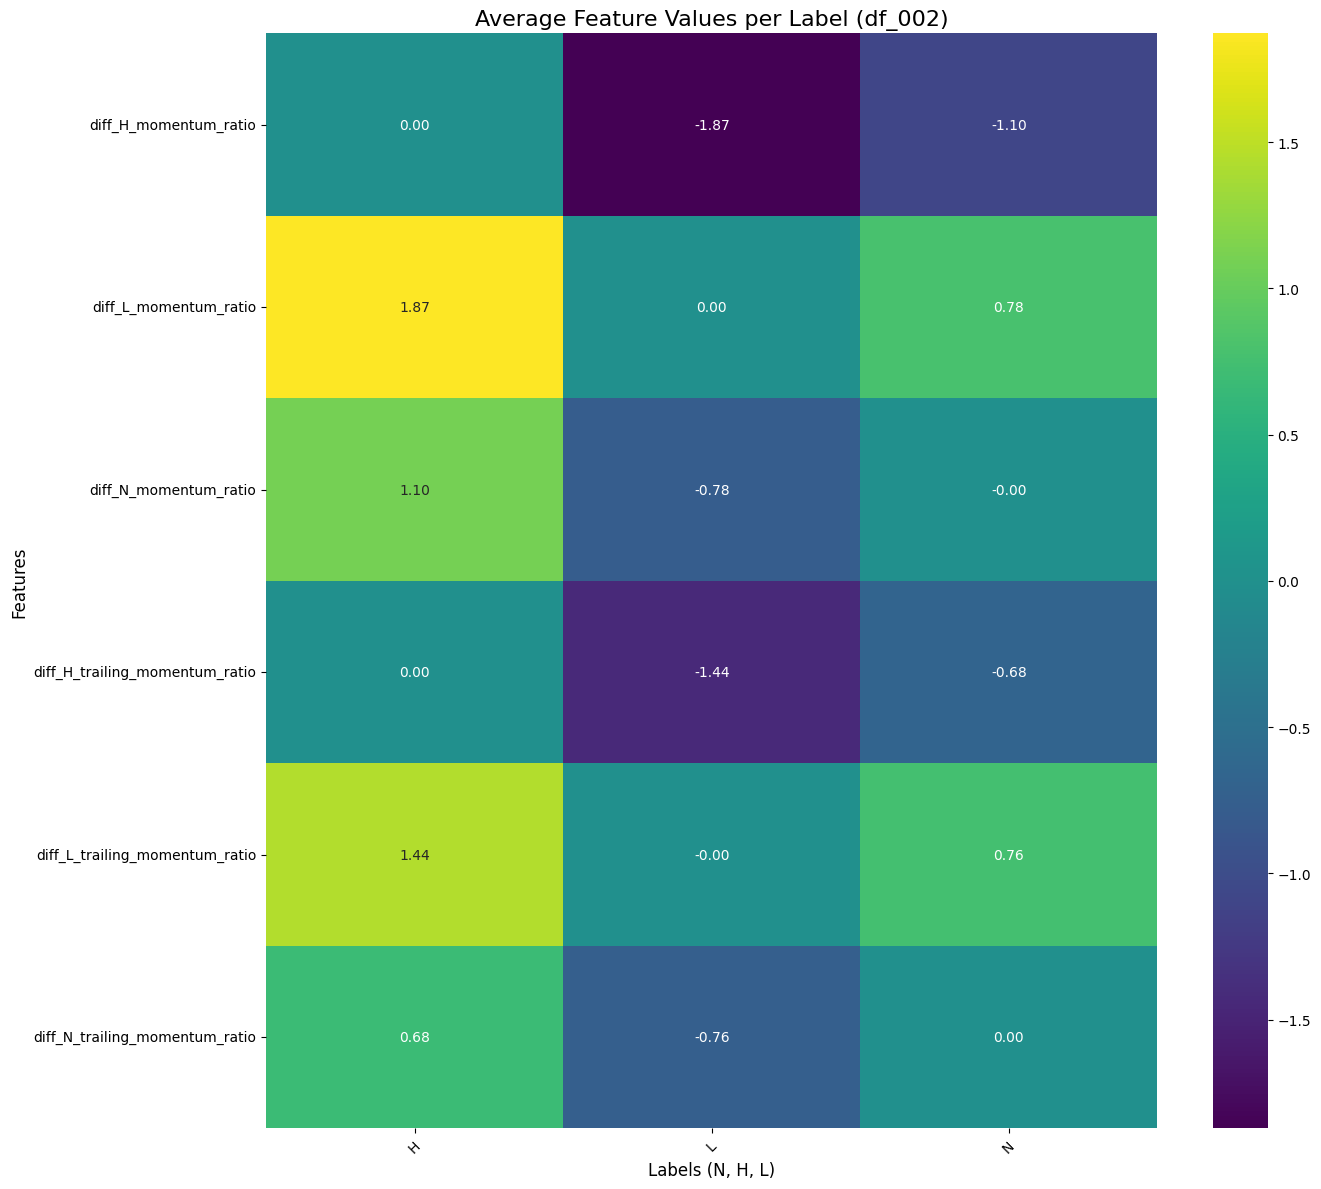

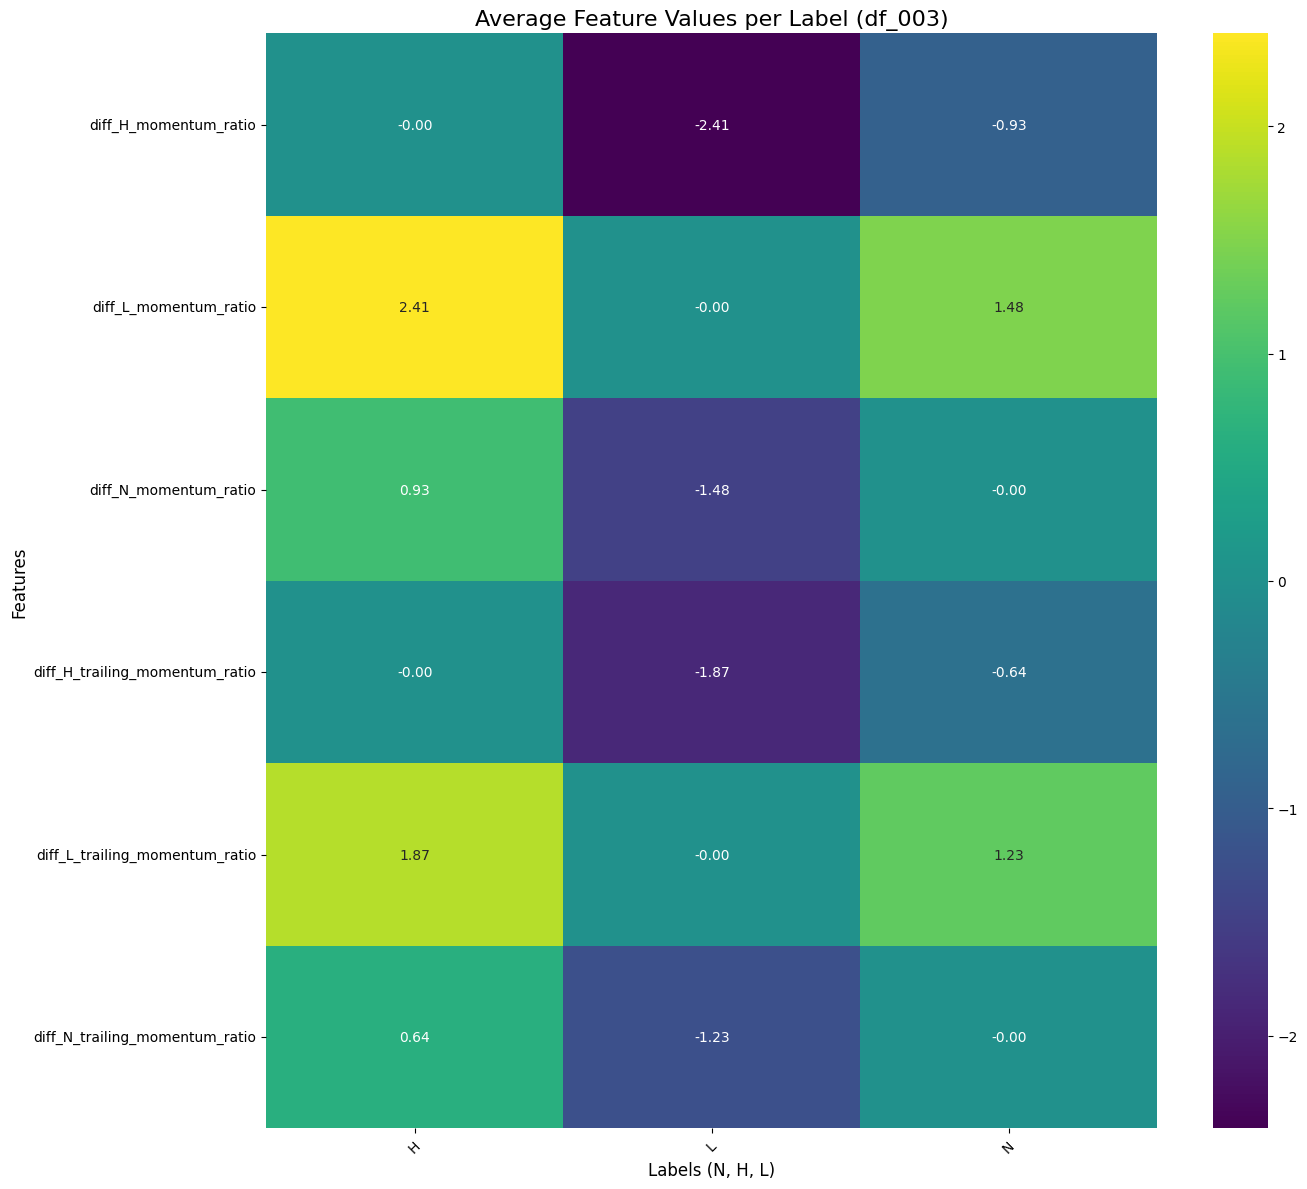

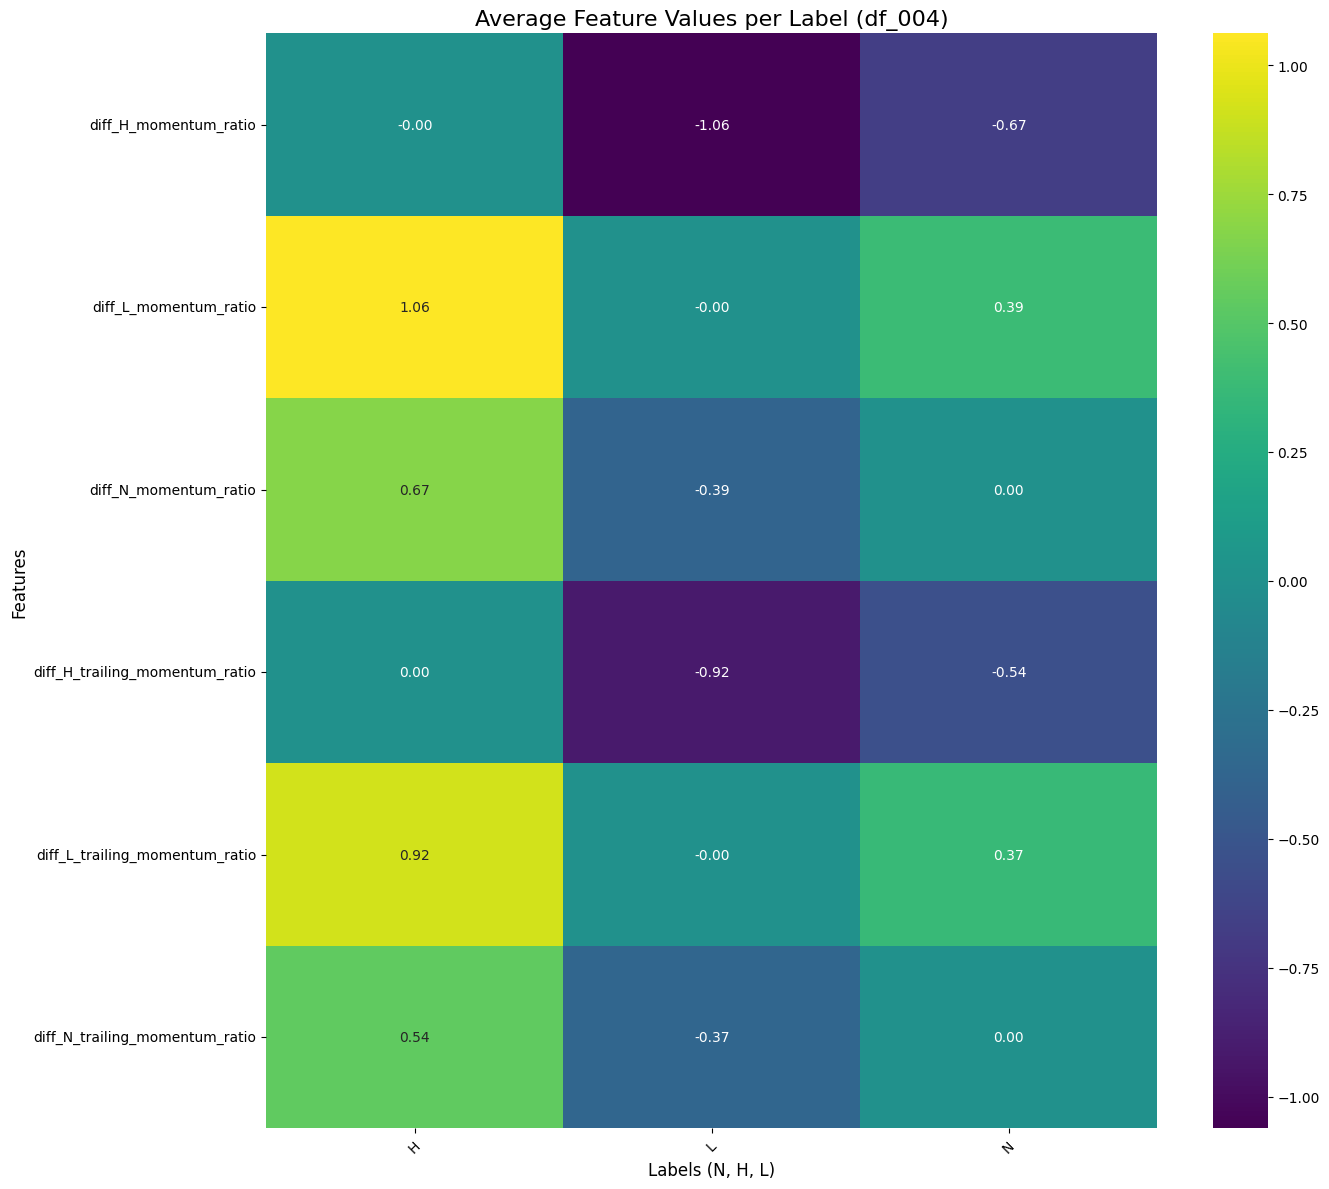

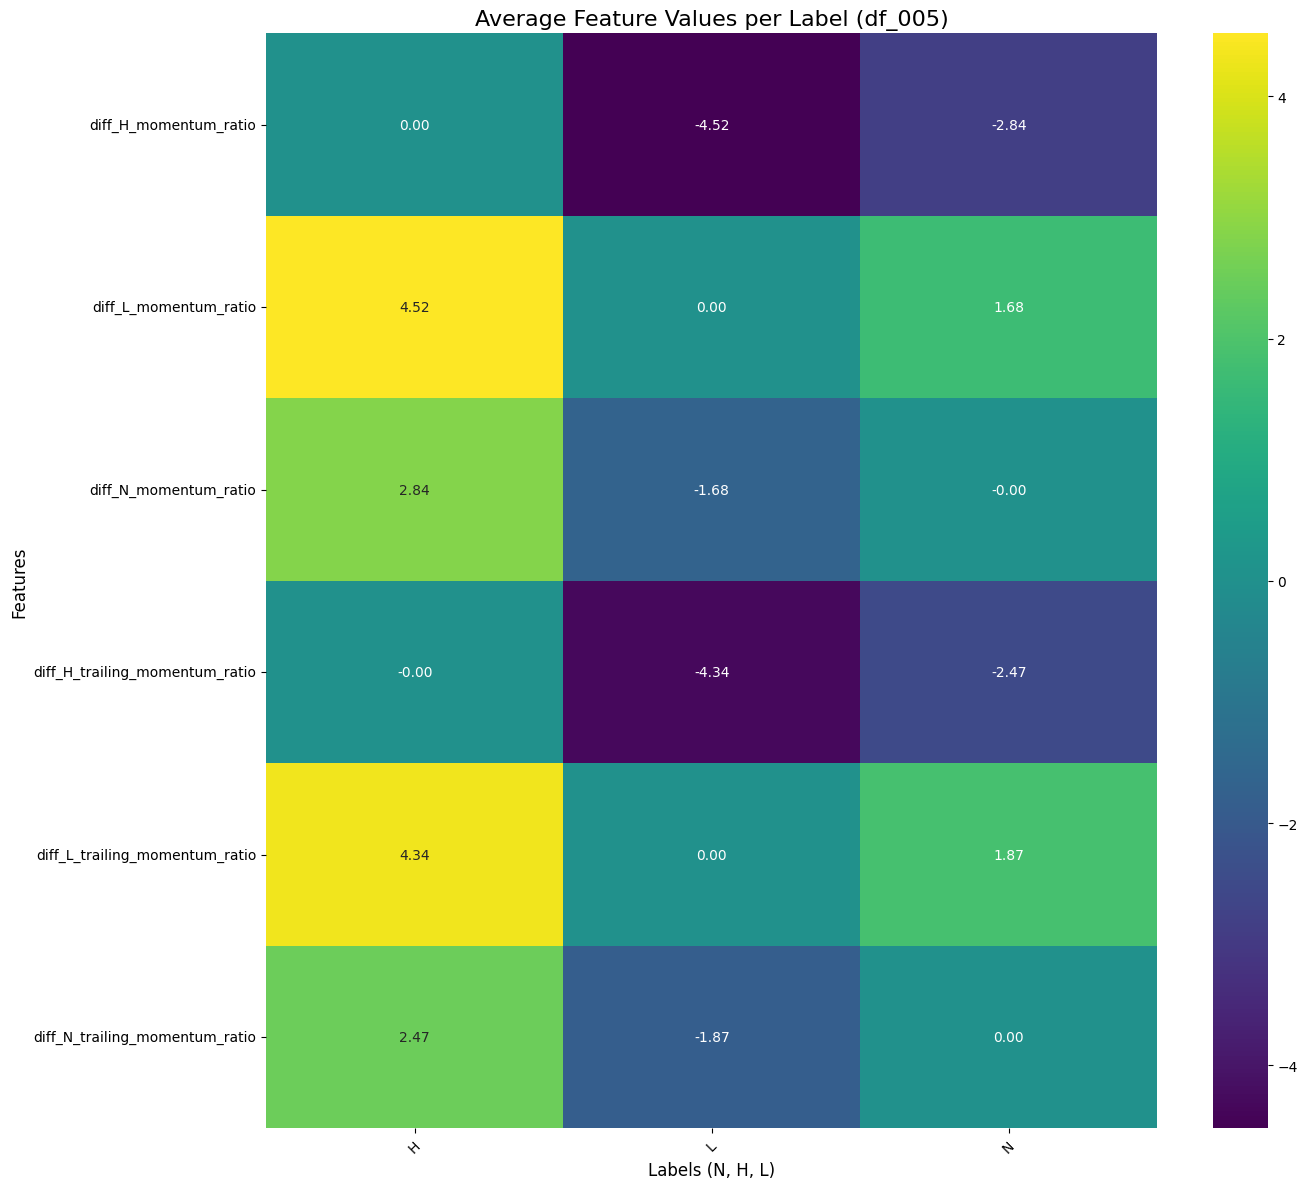

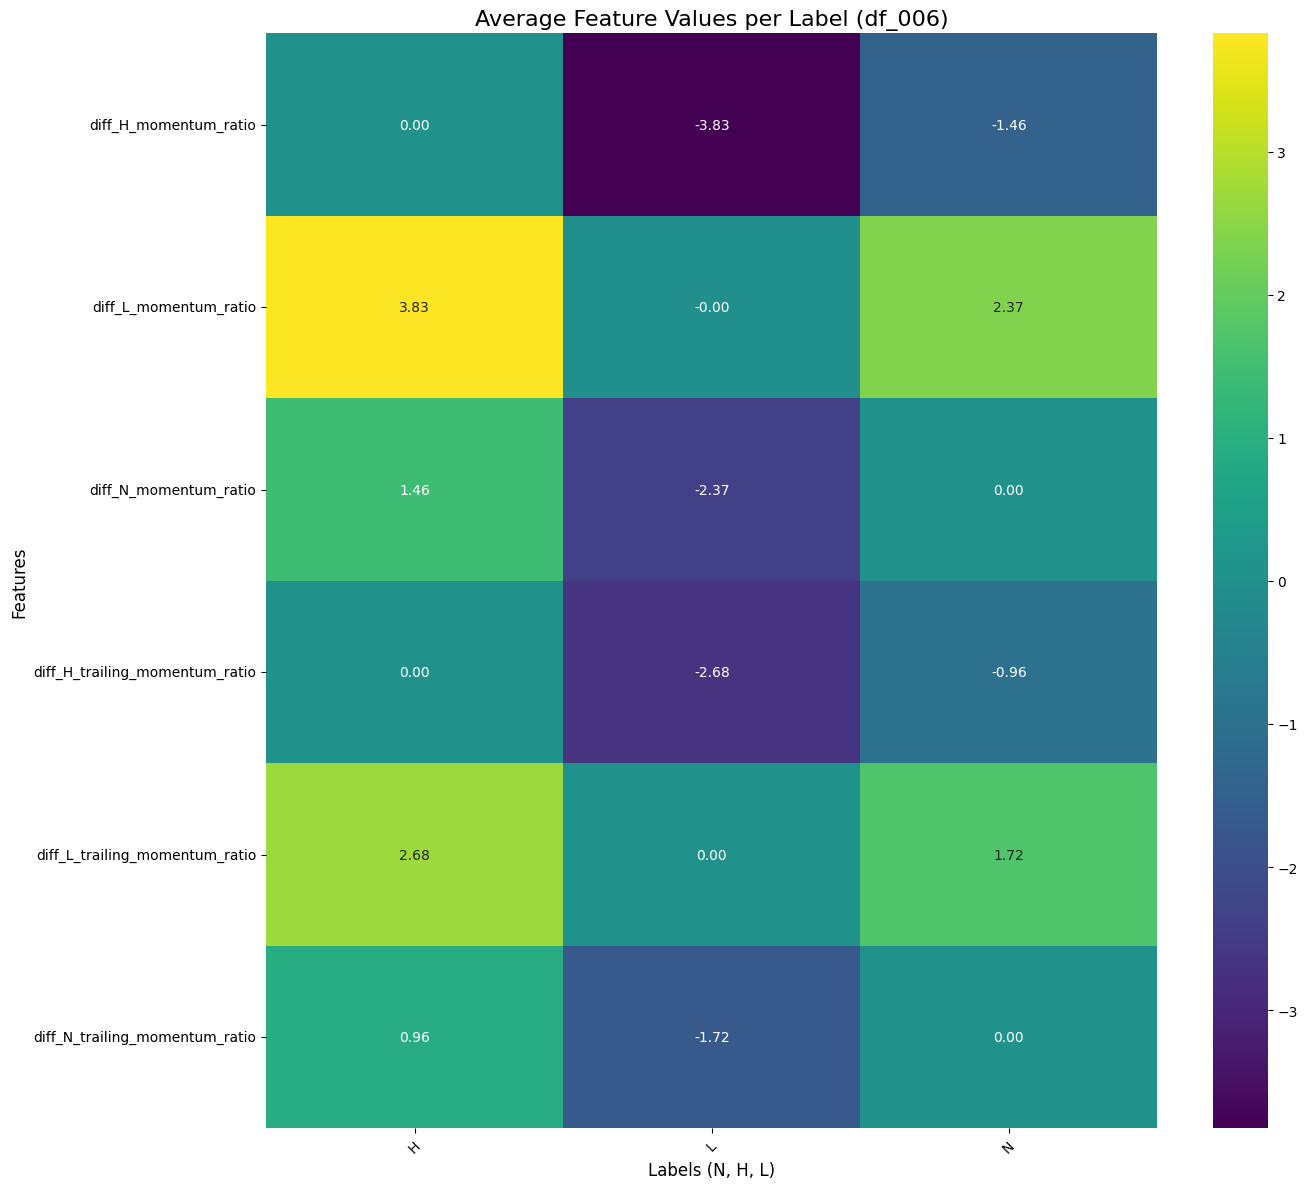

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Define the new columns created in the previous script
heatmap_columns = [
    'diff_H_momentum_ratio', 'diff_L_momentum_ratio', 'diff_N_momentum_ratio',
    'diff_H_trailing_momentum_ratio', 'diff_L_trailing_momentum_ratio', 'diff_N_trailing_momentum_ratio'
]

# List of dataframes to process
dfs = {
    "df": df,
    "df_001": df_001,
    "df_002": df_002,
    "df_003": df_003,
    "df_004": df_004,
    "df_005": df_005,
    "df_006": df_006
}

# Directory to store heatmap plots
output_dir = "Data_analysis_plots/features-label_heatmap/"

# Create directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Function to plot heatmap of average feature values per label and save to file
def plot_label_heatmap(dataframe, name):
    if set(heatmap_columns).issubset(dataframe.columns):
        label_means = dataframe.groupby("class_label")[heatmap_columns].mean()
        if not label_means.empty:
            plt.figure(figsize=(14, 12))
            sns.heatmap(
                label_means.T, annot=True, cmap='viridis', fmt=".2f",
                annot_kws={"size": 10}
            )
            plt.title(f'Average Feature Values per Label ({name})', fontsize=16)
            plt.xlabel("Labels (N, H, L)", fontsize=12)
            plt.ylabel("Features", fontsize=12)
            plt.xticks(rotation=45, fontsize=10)
            plt.yticks(fontsize=10)
            plt.tight_layout()
            # Save the plot to the specified directory
            # output_path = os.path.join(output_dir, f"heatmap_{name}.png")
            # plt.savefig(output_path, dpi=300, bbox_inches='tight')
            # plt.close()
            plt.show()

# Run for df and df_001 to df_006
for name, dataframe in dfs.items():
    plot_label_heatmap(dataframe, name)

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Assuming df_001 to df_006 are already processed and available
# Features to visualize
features = [
    'momentum_ratio', 'peaks', 'troughs',
    'within', 'trending', 'trending_momentum_boosted', 'within_momentum_boosted', 'trailing_momentum_ratio','momentum_ratio_diff'
]

# Directory to store box plots
output_dir = "Data_analysis_plots/features-label_boxplot/"

# Create directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Function to create box plots for a given DataFrame
def plot_distributions(df, df_name):
    # Ensure all features exist in the DataFrame
    available_features = [f for f in features if f in df.columns]
    
    if not available_features:
        print(f"No valid features found in {df_name}")
        return

    # Set the style for better visualization
    sns.set_style("whitegrid")

    # Create a figure for each DataFrame with multiple subplots
    n_features = len(available_features)
    fig, axes = plt.subplots(n_features, 1, figsize=(10, 5 * n_features), sharex=False)
    fig.suptitle(f'Feature Distributions by Class Label for {df_name}', fontsize=16)

    for idx, feature in enumerate(available_features):
        ax = axes[idx] if n_features > 1 else axes
        sns.boxplot(x='class_label', y=feature, data=df, ax=ax, palette="Set3")
        ax.set_title(f'{feature}')
        ax.set_xlabel('Class Label')
        ax.set_ylabel('Value')

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)

    # Save the plot to the specified directory
    plot_filename = os.path.join(output_dir, f"distribution_{df_name}.png")
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved distribution plot for {df_name} as {plot_filename}")

# Visualize distributions for each DataFrame
plot_distributions(df_001, 'df_001')
plot_distributions(df_002, 'df_002')
plot_distributions(df_003, 'df_003')
plot_distributions(df_004, 'df_004')
plot_distributions(df_005, 'df_005')
plot_distributions(df_006, 'df_006')

/tmp/ipykernel_494611/3894127732.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class_label', y=feature, data=df, ax=ax, palette="Set3")
/tmp/ipykernel_494611/3894127732.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class_label', y=feature, data=df, ax=ax, palette="Set3")
/tmp/ipykernel_494611/3894127732.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class_label', y=feature, data=df, ax=ax, palette="Set3")
/tmp/ipykernel_494611/3894127732.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is depreca

Saved distribution plot for df_001 as Data_analysis_plots/features-label_boxplot/distribution_df_001.png


/tmp/ipykernel_494611/3894127732.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class_label', y=feature, data=df, ax=ax, palette="Set3")
/tmp/ipykernel_494611/3894127732.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class_label', y=feature, data=df, ax=ax, palette="Set3")
/tmp/ipykernel_494611/3894127732.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class_label', y=feature, data=df, ax=ax, palette="Set3")
/tmp/ipykernel_494611/3894127732.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is depreca

Saved distribution plot for df_002 as Data_analysis_plots/features-label_boxplot/distribution_df_002.png


/tmp/ipykernel_494611/3894127732.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class_label', y=feature, data=df, ax=ax, palette="Set3")
/tmp/ipykernel_494611/3894127732.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class_label', y=feature, data=df, ax=ax, palette="Set3")
/tmp/ipykernel_494611/3894127732.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class_label', y=feature, data=df, ax=ax, palette="Set3")
/tmp/ipykernel_494611/3894127732.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is depreca

Saved distribution plot for df_003 as Data_analysis_plots/features-label_boxplot/distribution_df_003.png


/tmp/ipykernel_494611/3894127732.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class_label', y=feature, data=df, ax=ax, palette="Set3")
/tmp/ipykernel_494611/3894127732.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class_label', y=feature, data=df, ax=ax, palette="Set3")
/tmp/ipykernel_494611/3894127732.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class_label', y=feature, data=df, ax=ax, palette="Set3")
/tmp/ipykernel_494611/3894127732.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is depreca

Saved distribution plot for df_004 as Data_analysis_plots/features-label_boxplot/distribution_df_004.png


/tmp/ipykernel_494611/3894127732.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class_label', y=feature, data=df, ax=ax, palette="Set3")
/tmp/ipykernel_494611/3894127732.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class_label', y=feature, data=df, ax=ax, palette="Set3")
/tmp/ipykernel_494611/3894127732.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class_label', y=feature, data=df, ax=ax, palette="Set3")
/tmp/ipykernel_494611/3894127732.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is depreca

Saved distribution plot for df_005 as Data_analysis_plots/features-label_boxplot/distribution_df_005.png


/tmp/ipykernel_494611/3894127732.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class_label', y=feature, data=df, ax=ax, palette="Set3")
/tmp/ipykernel_494611/3894127732.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class_label', y=feature, data=df, ax=ax, palette="Set3")
/tmp/ipykernel_494611/3894127732.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class_label', y=feature, data=df, ax=ax, palette="Set3")
/tmp/ipykernel_494611/3894127732.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is depreca

Saved distribution plot for df_006 as Data_analysis_plots/features-label_boxplot/distribution_df_006.png
